Saaksshi Jilhewar - sjilhewa \
Gauri Dalwankar - gdalwank

In [28]:
#importing libraries

import findspark
import pyspark
import pyspark.sql.functions as F
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler

from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [2]:
#creating spark session

findspark.init()
findspark.find()

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("GenericAppName") \
    .getOrCreate()

In [3]:
#accessing dataset

train = spark.read.csv( (r"C:\Users\gauri\OneDrive\Desktop\mqtt project\data\train70_augmented.csv"),header=True, inferSchema= True)
test = spark.read.csv( (r"C:\Users\gauri\OneDrive\Desktop\mqtt project\data\test30_augmented.csv"),header=True, inferSchema= True)

In [4]:
#ingesting only a fraction of dataset because system kept showing error or no response from spark

x = train.head(140000)
y = test.head(60000)

DF_train = spark.createDataFrame(x)
DF_test = spark.createDataFrame(y)
DF = DF_train.union(DF_test)

In [ ]:
DF = DF.toDF(*(c.replace('.', '_') for c in DF.columns))
train = train.toDF(*(c.replace('.', '_') for c in train.columns))
test = test.toDF(*(c.replace('.', '_') for c in test.columns))

In [5]:
db_properties={}
#update your db username
db_properties['username']="postgres"
#update your db password
db_properties['password']="17032007"
#make sure you got the right port number here
db_properties['url']= "jdbc:postgresql://localhost:5432/postgres"
#make sure you had the Postgres JAR file in the right location
db_properties['driver']="org.postgresql.Driver"
db_properties['table']= "mqtt.MQTT"

DF.write.format("jdbc")\
.mode("overwrite")\
.option("url", db_properties['url'])\
.option("dbtable", db_properties['table'])\
.option("user", db_properties['username'])\
.option("password", db_properties['password'])\
.option("Driver", db_properties['driver'])\
.save()

In [6]:
spark = SparkSession.builder.appName("Basics").getOrCreate()
sc=spark.sparkContext
sqlContext = SQLContext(sc)

DF= sqlContext.read.format("jdbc")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("Driver", db_properties['driver'])\
    .load()

DF.show(1, vertical=True)

C:\Users\gauri\anaconda3\lib\site-packages\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


-RECORD 0--------------------------------
 tcp_flags                  | 0x00000018 
 tcp_time_delta             | 4.71E-4    
 tcp_len                    | 2          
 mqtt_conack_flags          | 0          
 mqtt_conack_flags_reserved | 0.0        
 mqtt_conack_flags_sp       | 0.0        
 mqtt_conack_val            | 0.0        
 mqtt_conflag_cleansess     | 1.0        
 mqtt_conflag_passwd        | 0.0        
 mqtt_conflag_qos           | 0.0        
 mqtt_conflag_reserved      | 0.0        
 mqtt_conflag_retain        | 0.0        
 mqtt_conflag_uname         | 0.0        
 mqtt_conflag_willflag      | 0.0        
 mqtt_conflags              | 0x00000002 
 mqtt_dupflag               | 0.0        
 mqtt_hdrflags              | 0x00000010 
 mqtt_kalive                | 65535.0    
 mqtt_len                   | 30.0       
 mqtt_msg                   | 0.0        
 mqtt_msgid                 | 0.0        
 mqtt_msgtype               | 1.0        
 mqtt_proto_len             | 4.0 

In [24]:
numeric_features = [feature[0] for feature in DF.dtypes if feature[1] in ('int','double')]
DF[numeric_features]

DataFrame[tcp_time_delta: double, mqtt_conack_flags_reserved: double, mqtt_conack_flags_sp: double, mqtt_conack_val: double, mqtt_conflag_cleansess: double, mqtt_conflag_passwd: double, mqtt_conflag_qos: double, mqtt_conflag_reserved: double, mqtt_conflag_retain: double, mqtt_conflag_uname: double, mqtt_conflag_willflag: double, mqtt_dupflag: double, mqtt_kalive: double, mqtt_len: double, mqtt_msgid: double, mqtt_msgtype: double, mqtt_proto_len: double, mqtt_qos: double, mqtt_retain: double, mqtt_sub_qos: double, mqtt_suback_qos: double, mqtt_ver: double, mqtt_willmsg: double, mqtt_willmsg_len: double, mqtt_willtopic: double, mqtt_willtopic_len: double]

In [ ]:
DF = DF.na.drop() #drop rows with null values

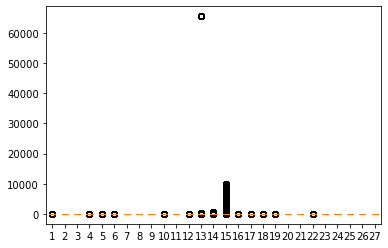

In [10]:
import matplotlib.pyplot as plt

#Extract data and convert them into Pandas for visualization
converted_data = DF[numeric_features].toPandas()
figure = plt.boxplot(converted_data)

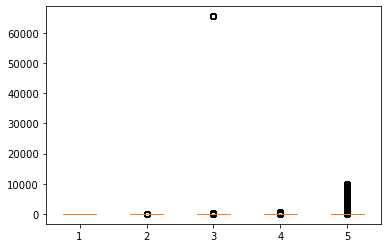

In [11]:
spotted_data = DF[numeric_features[14:18]].toPandas()
figure_subset = plt.boxplot(spotted_data)

In [13]:
from functools import reduce

def column_add(a,b):
     return  a.__add__(b)
    
def find_outliers(df):
    # Identifying the numerical columns in a spark dataframe
    numeric_columns = [column[0] for column in df.dtypes if column[1]=='int']

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        df = df.withColumn(isOutlierCol,when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]
    # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
    df = df.withColumn('total_outliers',reduce(column_add, ( df[col] for col in  selected_columns)))

    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df

In [14]:
df_with_outlier_handling = find_outliers(DF)
df_with_outlier_handling.show(1, vertical=True)

-RECORD 0--------------------------------
 tcp_flags                  | 0x00000018 
 tcp_time_delta             | 4.71E-4    
 tcp_len                    | 2          
 mqtt_conack_flags          | 0          
 mqtt_conack_flags_reserved | 0.0        
 mqtt_conack_flags_sp       | 0.0        
 mqtt_conack_val            | 0.0        
 mqtt_conflag_cleansess     | 1.0        
 mqtt_conflag_passwd        | 0.0        
 mqtt_conflag_qos           | 0.0        
 mqtt_conflag_reserved      | 0.0        
 mqtt_conflag_retain        | 0.0        
 mqtt_conflag_uname         | 0.0        
 mqtt_conflag_willflag      | 0.0        
 mqtt_conflags              | 0x00000002 
 mqtt_dupflag               | 0.0        
 mqtt_hdrflags              | 0x00000010 
 mqtt_kalive                | 65535.0    
 mqtt_len                   | 30.0       
 mqtt_msg                   | 0.0        
 mqtt_msgid                 | 0.0        
 mqtt_msgtype               | 1.0        
 mqtt_proto_len             | 4.0 

In [15]:
df_with_outlier_handling.groupby("total_outliers").count().show()

+--------------+------+
|total_outliers| count|
+--------------+------+
|             0|200000|
+--------------+------+



In [16]:
DF=DF.drop('Field')

In [34]:
DF.printSchema()

root
 |-- tcp_flags: string (nullable = true)
 |-- tcp_time_delta: double (nullable = true)
 |-- tcp_len: long (nullable = true)
 |-- mqtt_conack_flags: string (nullable = true)
 |-- mqtt_conack_flags_reserved: double (nullable = true)
 |-- mqtt_conack_flags_sp: double (nullable = true)
 |-- mqtt_conack_val: double (nullable = true)
 |-- mqtt_conflag_cleansess: double (nullable = true)
 |-- mqtt_conflag_passwd: double (nullable = true)
 |-- mqtt_conflag_qos: double (nullable = true)
 |-- mqtt_conflag_reserved: double (nullable = true)
 |-- mqtt_conflag_retain: double (nullable = true)
 |-- mqtt_conflag_uname: double (nullable = true)
 |-- mqtt_conflag_willflag: double (nullable = true)
 |-- mqtt_conflags: string (nullable = true)
 |-- mqtt_dupflag: double (nullable = true)
 |-- mqtt_hdrflags: string (nullable = true)
 |-- mqtt_kalive: double (nullable = true)
 |-- mqtt_len: double (nullable = true)
 |-- mqtt_msg: string (nullable = true)
 |-- mqtt_msgid: double (nullable = true)
 |-- m

In [36]:
col_names = ['tcp_flags',
 'tcp_time_delta',
 'tcp_len',
 'mqtt_conack_flags',
 'mqtt_conack_flags_reserved',
 'mqtt_conack_flags_sp',
 'mqtt_conack_val',
 'mqtt_conflag_cleansess',
 'mqtt_conflag_passwd',
 'mqtt_conflag_qos',
 'mqtt_conflag_reserved',
 'mqtt_conflag_retain',
 'mqtt_conflag_uname',
 'mqtt_conflag_willflag',
 'mqtt_conflags',
 'mqtt_dupflag',
 'mqtt_hdrflags',
 'mqtt_kalive',
 'mqtt_len',
 'mqtt_msg',
 'mqtt_msgid',
 'mqtt_msgtype',
 'mqtt_proto_len',
 'mqtt_qos',
 'mqtt_retain',
 'mqtt_sub_qos',
 'mqtt_suback_qos',
 'mqtt_ver',
 'mqtt_willmsg',
 'mqtt_willmsg_len',
 'mqtt_willtopic',
 'mqtt_willtopic_len',
 'target']

nominal_cols = ['tcp_flags',
 'mqtt_conack_flags',
 'mqtt_conflags',
 'mqtt_hdrflags',
 'mqtt_msg',
 'mqtt_protoname']

continuous_cols = ['tcp_time_delta',
 'tcp_len',
 'mqtt_conack_flags_reserved',
 'mqtt_conack_flags_sp',
 'mqtt_conack_val',
 'mqtt_conflag_cleansess',
 'mqtt_conflag_passwd',
 'mqtt_conflag_qos',
 'mqtt_conflag_reserved',
 'mqtt_conflag_retain',
 'mqtt_conflag_uname',
 'mqtt_conflag_willflag',
 'mqtt_dupflag',
 'mqtt_kalive',
 'mqtt_len',
 'mqtt_msgid',
 'mqtt_msgtype',
 'mqtt_proto_len',
 'mqtt_qos',
 'mqtt_retain',
 'mqtt_sub_qos',
 'mqtt_suback_qos',
 'mqtt_ver',
 'mqtt_willmsg',
 'mqtt_willmsg_len',
 'mqtt_willtopic',
 'mqtt_willtopic_len']

In [37]:
DF[numeric_features]

DataFrame[tcp_time_delta: double, mqtt_conack_flags_reserved: double, mqtt_conack_flags_sp: double, mqtt_conack_val: double, mqtt_conflag_cleansess: double, mqtt_conflag_passwd: double, mqtt_conflag_qos: double, mqtt_conflag_reserved: double, mqtt_conflag_retain: double, mqtt_conflag_uname: double, mqtt_conflag_willflag: double, mqtt_dupflag: double, mqtt_kalive: double, mqtt_len: double, mqtt_msgid: double, mqtt_msgtype: double, mqtt_proto_len: double, mqtt_qos: double, mqtt_retain: double, mqtt_sub_qos: double, mqtt_suback_qos: double, mqtt_ver: double, mqtt_willmsg: double, mqtt_willmsg_len: double, mqtt_willtopic: double, mqtt_willtopic_len: double]

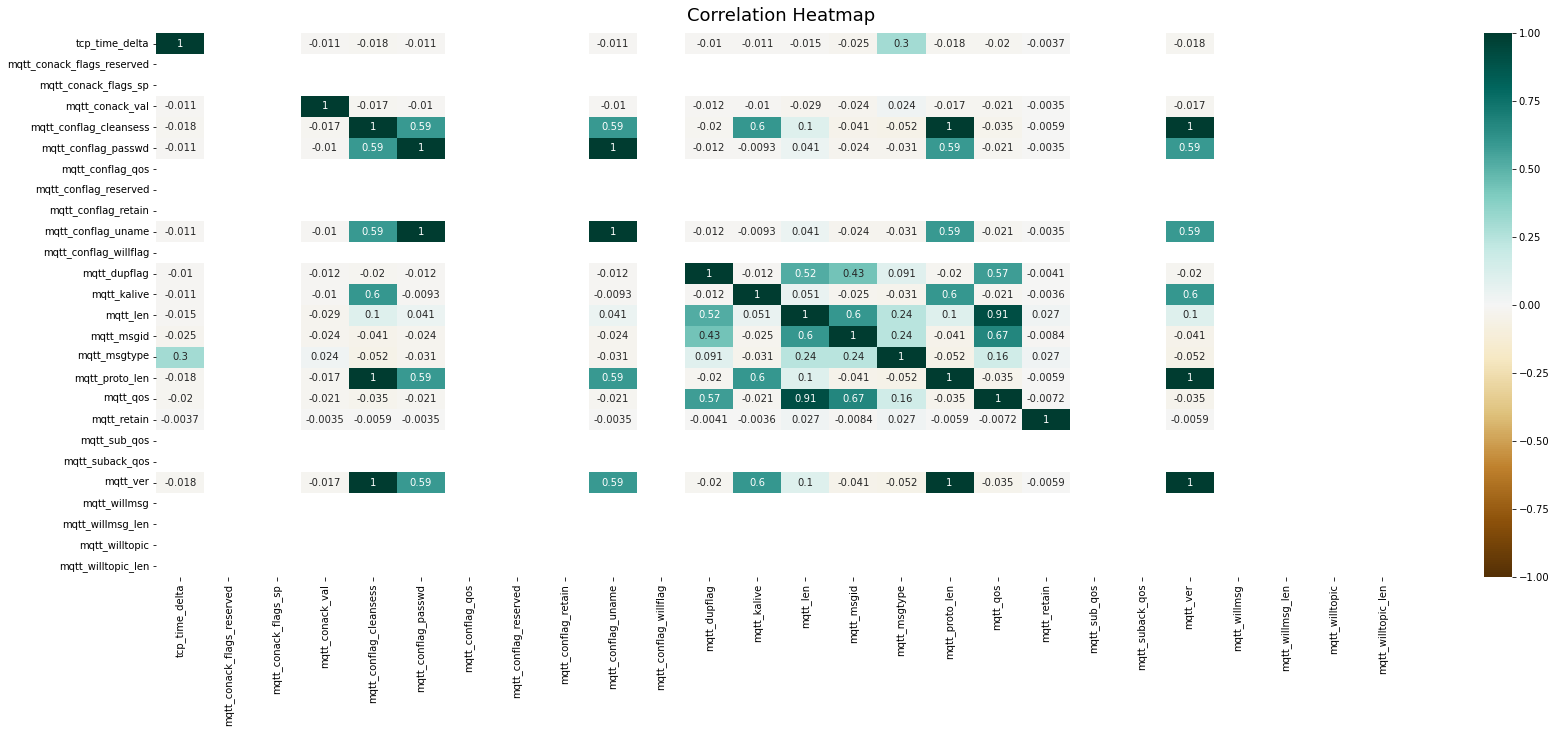

In [38]:
# DF = DF.to_frame()
# corr = DF.corr()
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(28, 10))
heatmap = sns.heatmap(DF[numeric_features].toPandas().corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
plt.savefig('corr_heatmap.png', dpi=300, bbox_inches='tight')

C:\Users\gauri\AppData\Local\Temp\ipykernel_10160\2392346778.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(DF[numeric_features].toPandas().corr(), dtype=np.bool))


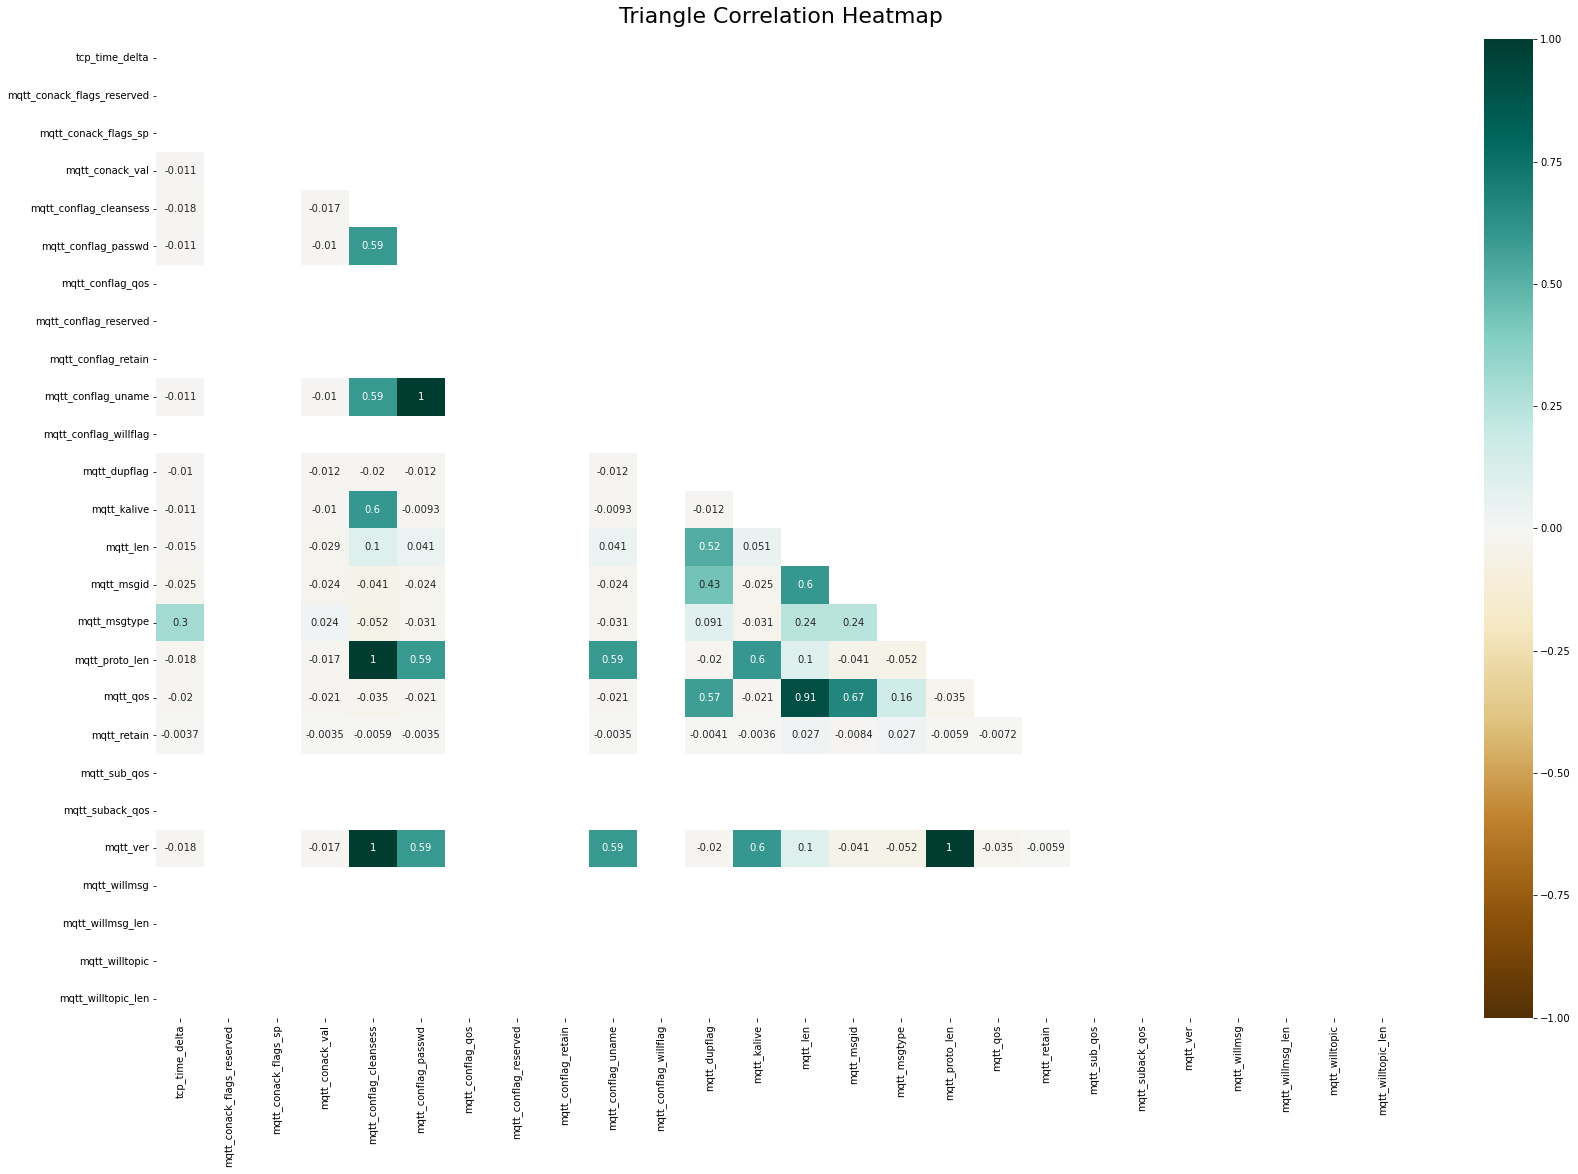

In [39]:
plt.figure(figsize=(28, 18))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(DF[numeric_features].toPandas().corr(), dtype=np.bool))
heatmap = sns.heatmap(DF[numeric_features].toPandas().corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':22}, pad=16);

In [30]:
cor_matrix = DF.toPandas().corr()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))

C:\Users\gauri\AppData\Local\Temp\ipykernel_10160\240250053.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))


In [40]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.89)]
print(); print(to_drop)


['mqtt_conflag_uname', 'mqtt_proto_len', 'mqtt_qos', 'mqtt_ver']


In [55]:
DF.select("target").distinct().collect()

[Row(target='slowite'),
 Row(target='bruteforce'),
 Row(target='flood'),
 Row(target='malformed'),
 Row(target='dos'),
 Row(target='legitimate')]